In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Libraries**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from shapely.geometry import Point
from shapely import wkt
import geopandas as gpd

In [2]:
file_path = '/content/drive/MyDrive/datasets/aligned_viirs_ookla_2022.csv'
df = pd.read_csv(file_path)

df.head()

,Longitude,Latitude,Light_intesity,geometry,index_right,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry_wkt,quarter
0,2.570833,51.1,4.379785,POINT (2.570833354253705 51.10000040919949),864709,1202020331030322,87145,16421,13,7,5,"POLYGON ((2.57080078125 51.1000725724061, 2.57...",Q3
1,2.570833,51.1,4.379785,POINT (2.570833354253705 51.10000040919949),472577,1202020331030322,89687,13885,14,12,6,"POLYGON ((2.57080078125 51.1000725724061, 2.57...",Q2
2,2.570833,51.1,4.379785,POINT (2.570833354253705 51.10000040919949),73278,1202020331030322,37705,11653,14,3,3,"POLYGON ((2.57080078125 51.1000725724061, 2.57...",Q1
3,2.575000,51.1,8.629868,POINT (2.5750000209537927 51.10000040919949),864709,1202020331030322,87145,16421,13,7,5,"POLYGON ((2.57080078125 51.1000725724061, 2.57...",Q3
4,2.575000,51.1,8.629868,POINT (2.5750000209537927 51.10000040919949),472577,1202020331030322,89687,13885,14,12,6,"POLYGON ((2.57080078125 51.1000725724061, 2.57...",Q2


# **Dimensionally reduction (download & upload internet speed - latency - tests) --> internet performance**

In [4]:
# Define the min and max ranges for each metric
download_min, download_max = df['avg_d_kbps'].min(), df['avg_d_kbps'].max()
upload_min, upload_max = df['avg_u_kbps'].min(), df['avg_u_kbps'].max()
latency_min, latency_max = df['avg_lat_ms'].min(), df['avg_lat_ms'].max()
test_min, test_max = df['tests'].min(), df['tests'].max()

# Ensure there are no division-by-zero errors in normalization
download_range = download_max - download_min
upload_range = upload_max - upload_min
latency_range = latency_max - latency_min
test_range = test_max - test_min

# Normalize each metric using min-max normalization
df['download_normalized'] = (df['avg_d_kbps'] - download_min) / download_range
df['upload_normalized'] = (df['avg_u_kbps'] - upload_min) / upload_range
df['latency_normalized'] = (df['avg_lat_ms'] - latency_min) / latency_range
df['latency_adjusted'] = 1 - df['latency_normalized']  # Invert latency (lower is better)
df['test_normalized'] = (df['tests'] - test_min) / test_range

# Define weights for each metric
weights = {
    'download': 0.5,
    'upload': 0.3,
    'latency': 0.2
}

# Calculate the weighted performance score
df['internet_performance'] = (
    weights['download'] * df['download_normalized'] +
    weights['upload'] * df['upload_normalized'] +
    weights['latency'] * df['latency_adjusted']
)

# Include test counts as a reliability factor
df['final_performance'] = df['internet_performance'] * df['test_normalized']

print(df[['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'final_performance']].head())


   avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  final_performance
0       87145       16421          13      7           0.000471
1       89687       13885          14     12           0.000864
2       37705       11653          14      3           0.000148
3       87145       16421          13      7           0.000471
4       89687       13885          14     12           0.000864


In [5]:
cr = df['Light_intesity'].corr(df['final_performance'])
print(cr)

0.35884732928884966


# Light intensity values sorted **bold text**

In [6]:
un = np.sort(np.unique(df['Light_intesity']))
print(un)

[3.0413824e-01 3.0665877e-01 3.0688158e-01 ... 3.2903550e+02 3.6172556e+02
 4.2447156e+02]


# EDA and Visualizations:
1.	Time-Series Plot:
    Show radiance and internet speed variations during outage periods.
2.	Scatter Plot:
    Correlate drops in radiance with internet performance declines.
3.	Geospatial Overlay:
    Map affected regions during detected outages.
4.	Bar Chart:
    Compare outage durations and severity across regions.
5.	Heatmap:
    Highlight regions prone to frequent power outages.



# **Scatter plot between longitude and latitude to plot the area working on (FRANCE) in map**

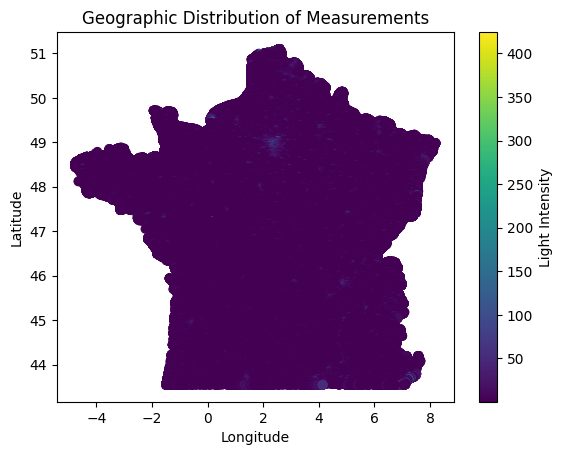

In [7]:
plt.scatter(df['Longitude'], df['Latitude'], c=df['Light_intesity'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Measurements')
plt.colorbar(label='Light Intensity')
plt.show()

# **Correlations**

# **Scatter plots and correlations visualization**

Text(0, 0.5, 'count')

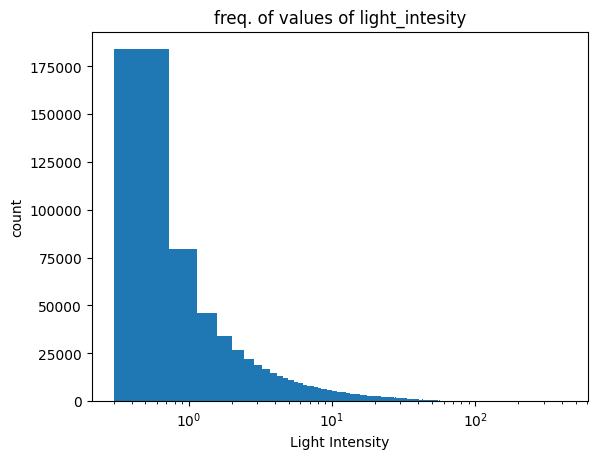

In [8]:
plt.hist(data = df, x = 'Light_intesity', bins = 1000);
plt.xscale('log')
plt.title('freq. of values of light_intesity')
plt.xlabel('Light Intensity')
plt.ylabel('count')

# Scatter plot Light_intesity and avg_d_kbps




                Light_intesity  avg_d_kbps
Light_intesity        1.000000    0.173411
avg_d_kbps            0.173411    1.000000


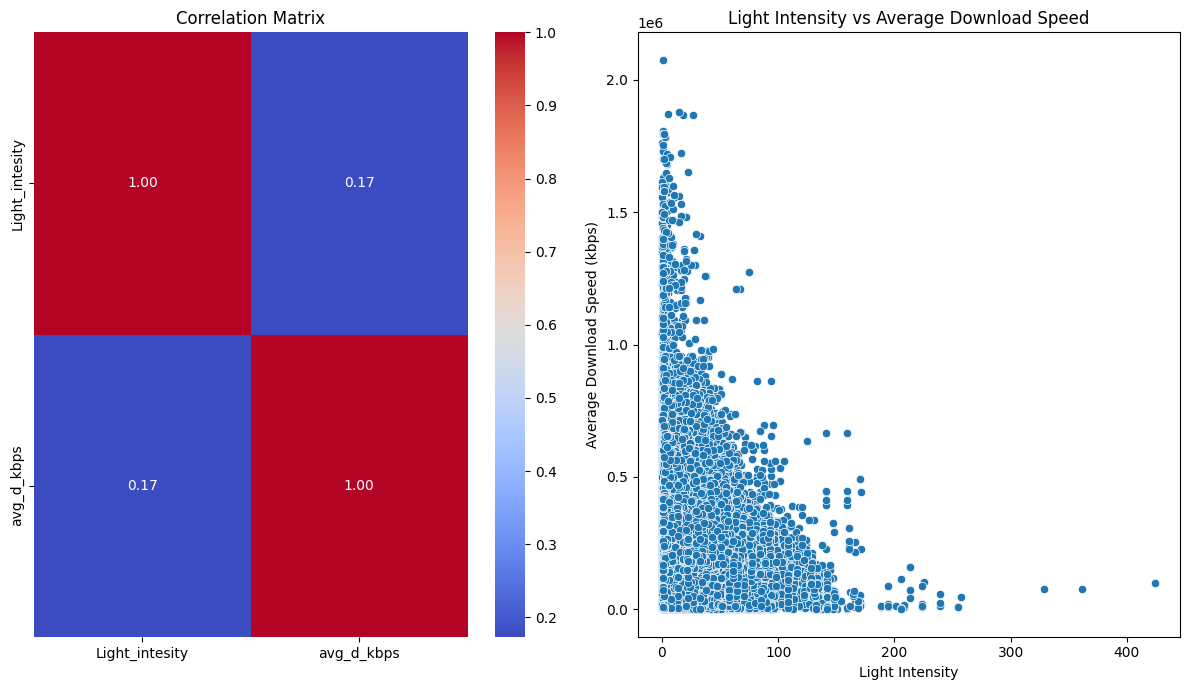

In [9]:
# Light Intensity vs Average Download Speed
# Calculate correlation matrix
corr_matrix = df[['Light_intesity', 'avg_d_kbps']].corr()
print(corr_matrix)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 7))

# First subplot: Correlation matrix heatmap
plt.subplot(1, 2, 1)
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

# Second subplot: Scatter plot
plt.subplot(1, 2, 2)
sb.scatterplot(data=df, x='Light_intesity', y='avg_d_kbps')
plt.title('Light Intensity vs Average Download Speed')
plt.xlabel('Light Intensity')
plt.ylabel('Average Download Speed (kbps)')

# Display the plots
plt.tight_layout()
plt.show()

# Scatter plot Light_intesity and avg_u_kbps

                Light_intesity  avg_u_kbps
Light_intesity        1.000000    0.146271
avg_u_kbps            0.146271    1.000000


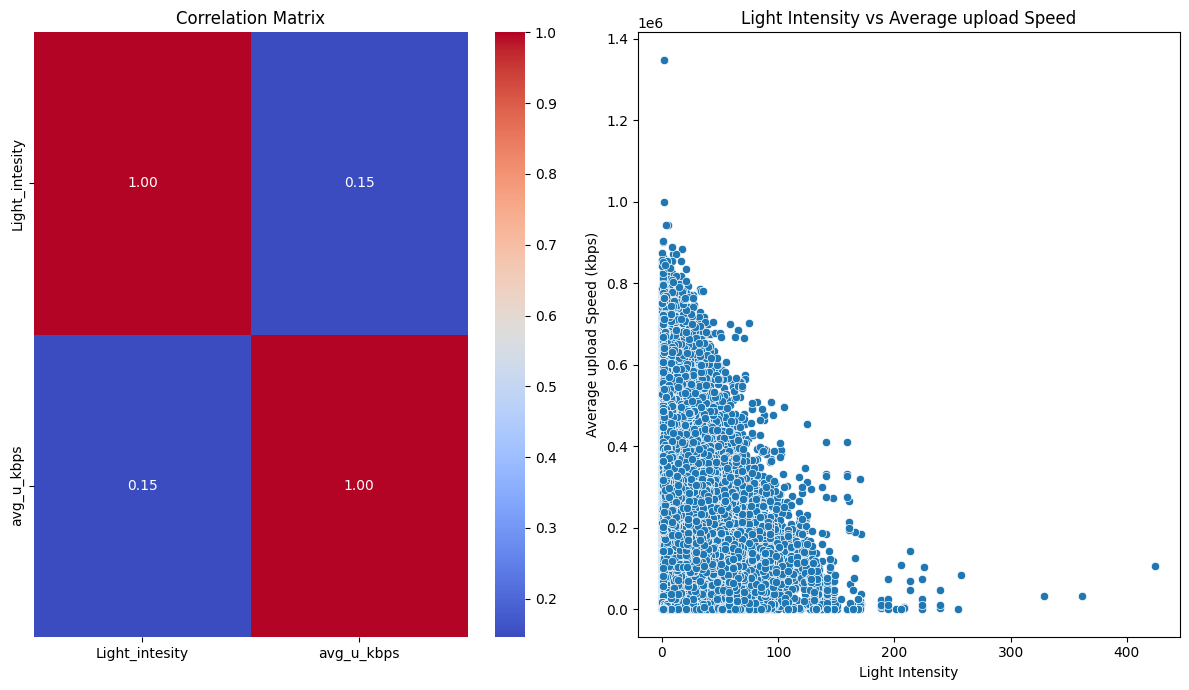

In [10]:
corr_matrix = df[['Light_intesity', 'avg_u_kbps']].corr()
print(corr_matrix)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 7))

# First subplot: Correlation matrix heatmap
plt.subplot(1, 2, 1)
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

# Second subplot: Scatter plot
plt.subplot(1, 2, 2)
sb.scatterplot(data=df, x='Light_intesity', y='avg_u_kbps')
plt.title('Light Intensity vs Average upload Speed')
plt.xlabel('Light Intensity')
plt.ylabel('Average upload Speed (kbps)')

# Display the plots
plt.tight_layout()
plt.show()

# Scatter plot Light_intesity and devices



                Light_intesity   devices
Light_intesity        1.000000  0.550587
devices               0.550587  1.000000


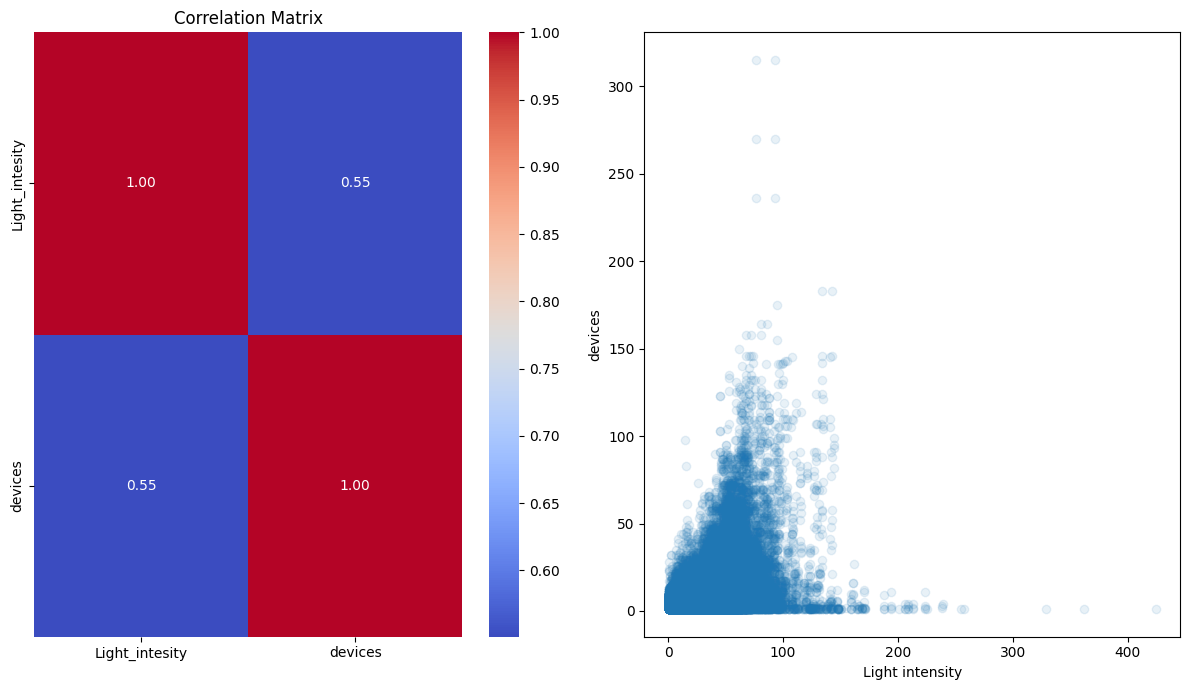

In [11]:
corr_matrix = df[['Light_intesity', 'devices']].corr()
print(corr_matrix)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 7))

# First subplot: Correlation matrix heatmap
plt.subplot(1, 2, 1)
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

# Second subplot: Scatter plot
plt.subplot(1, 2, 2)
sb.regplot(data = df, x = 'Light_intesity', y = 'devices', x_jitter=0.04, scatter_kws={'alpha':1/10}, fit_reg=False)
plt.xlabel('Light intensity')
plt.ylabel('devices');

# Display the plots
plt.tight_layout()
plt.show()


# Scatter plot Light_intesity and final_performance


                   Light_intesity  final_performance
Light_intesity           1.000000           0.358847
final_performance        0.358847           1.000000


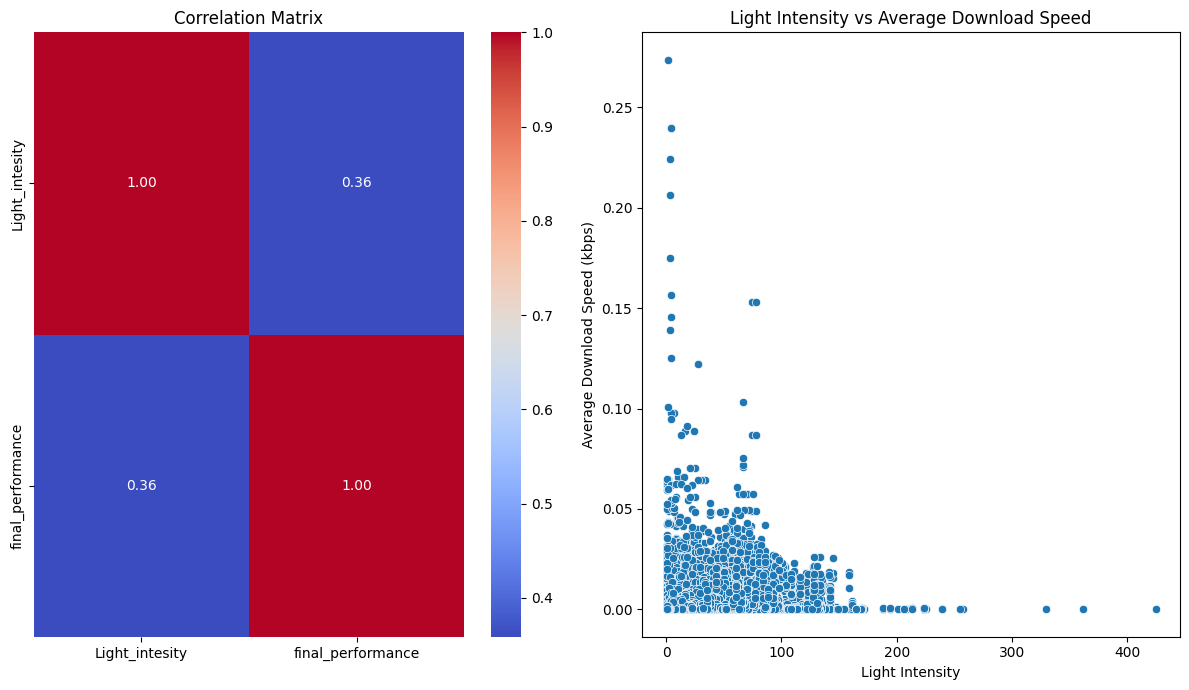

In [12]:
# Light Intensity vs Average Download Speed
# Calculate correlation matrix
corr_matrix = df[['Light_intesity', 'final_performance']].corr()
print(corr_matrix)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 7))

# First subplot: Correlation matrix heatmap
plt.subplot(1, 2, 1)
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

# Second subplot: Scatter plot
plt.subplot(1, 2, 2)
sb.scatterplot(data=df, x='Light_intesity', y='final_performance')
plt.title('Light Intensity vs Average Download Speed')
plt.xlabel('Light Intensity')
plt.ylabel('Average Download Speed (kbps)')

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
print("correlation between light intensity and download speed:",df["Light_intesity"].corr(df["avg_d_kbps"]))
print("correlation between light intensity and internet performance:",df["Light_intesity"].corr(df["final_performance"]))
print("correlation between light intensity and latency:",df["Light_intesity"].corr(df["avg_lat_ms"]))
print("correlation between light intensity and devices:",df["Light_intesity"].corr(df["devices"]))
print("correlation between download speed and devices:",df["avg_d_kbps"].corr(df["devices"]))

correlation between light intensity and download speed: 0.17341121014624536
correlation between light intensity and internet performance: 0.35884732928885105
correlation between light intensity and latency: -0.09776281136323599
correlation between light intensity and devices: 0.5505870958337634
correlation between download speed and devices: 0.10163976684753771


# **Scatter PLot (Correlate drops in radiance with internet performance declines.)**

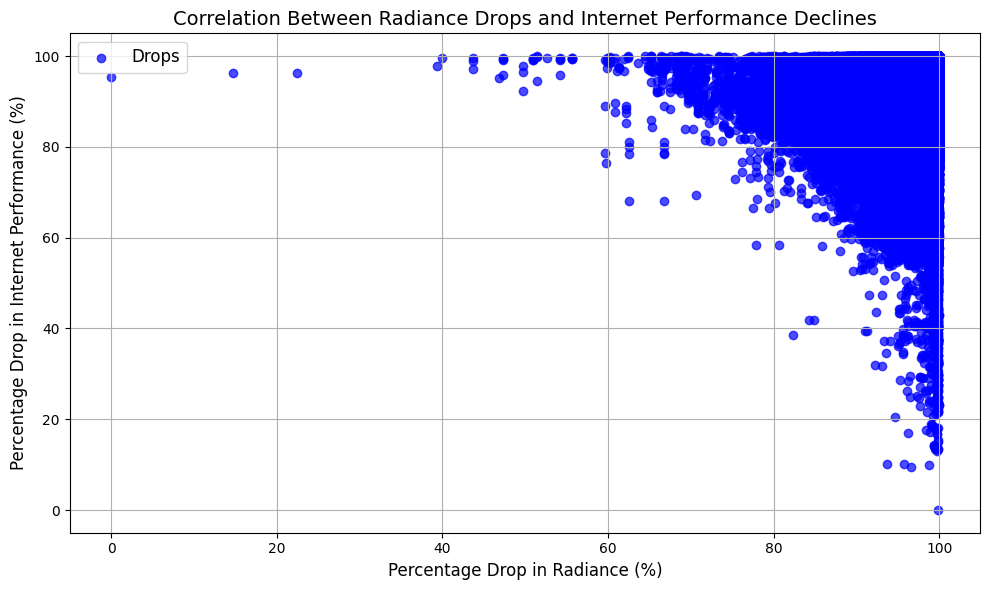

In [14]:
df3 = df

# Assuming df3 is already loaded and has the specified columns
# Calculating percentage drops in radiance and internet performance
df3['radiance_drop_percentage'] = (df3['Light_intesity'].max() - df3['Light_intesity']) / df3['Light_intesity'].max() * 100
df3['internet_drop_percentage'] = (df3['avg_d_kbps'].max() - df3['avg_d_kbps']) / df3['avg_d_kbps'].max() * 100

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df3['radiance_drop_percentage'], df3['internet_drop_percentage'], color='blue', alpha=0.7, label='Drops')

# Adding labels, title, and legend
plt.title('Correlation Between Radiance Drops and Internet Performance Declines', fontsize=14)
plt.xlabel('Percentage Drop in Radiance (%)', fontsize=12)
plt.ylabel('Percentage Drop in Internet Performance (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# **Bar Chart (Compare outage durations and severity across regions)**

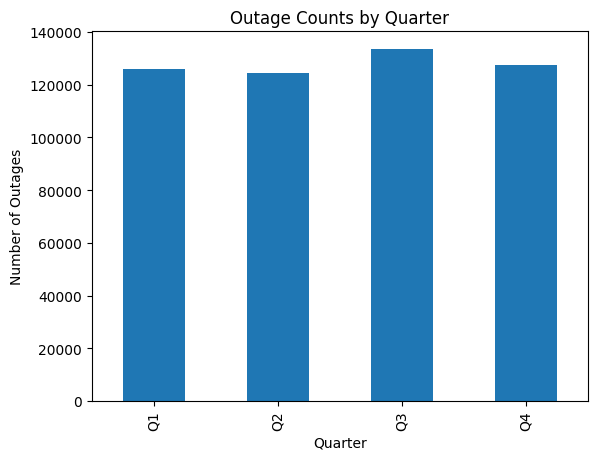

In [10]:
outage_counts = df.groupby('quarter')['power_outage'].sum()
outage_counts.sort_values(ascending=False)
import matplotlib.pyplot as plt
outage_counts.plot(kind='bar')
plt.title('Outage Counts by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Outages')
plt.show()

# **Geospatial Overlay (Map affected regions during detected outages)**


<Figure size 1200x800 with 0 Axes>

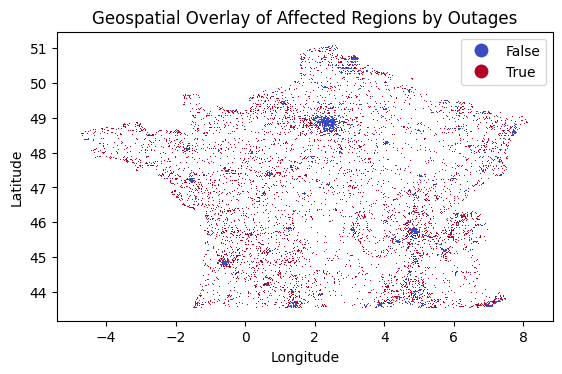

In [11]:
# Convert the 'geometry_wkt' column to Shapely geometries
df['geometry'] = df['geometry_wkt'].apply(wkt.loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Plot the geospatial overlay visualization
plt.figure(figsize=(12, 8))
gdf.plot(column='power_outage', cmap='coolwarm', legend=True)
# Add plot details
plt.title('Geospatial Overlay of Affected Regions by Outages')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# **Time-series plot (Show radiance and internet speed variations during outage periods)**

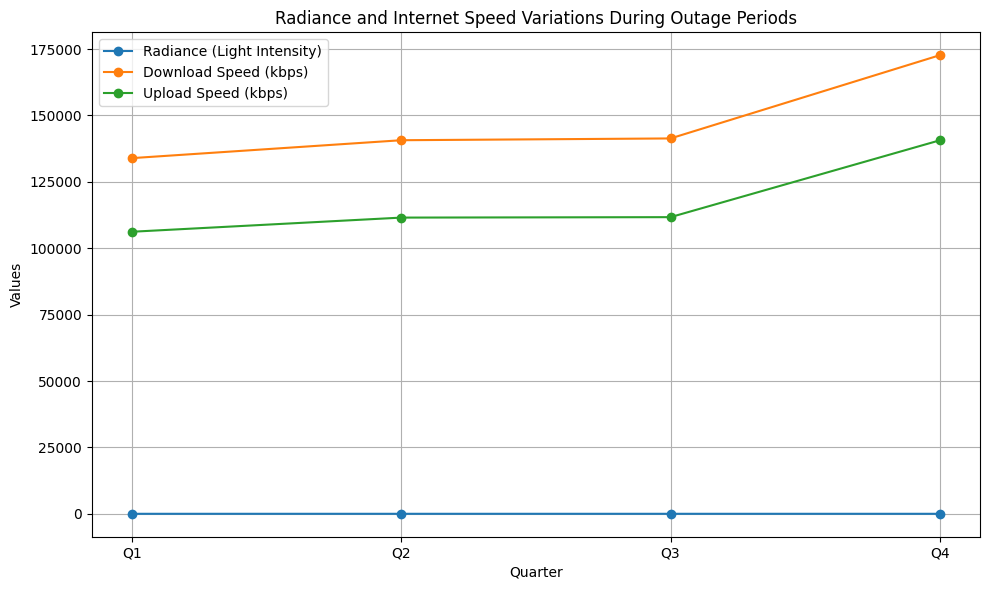

In [16]:
df2 = df
# Filter for outage periods
outage_data = df2[df2['power_outage'] == True]

# Group by quarter and calculate the mean for relevant columns
aggregated = outage_data.groupby('quarter')[['Light_intesity', 'avg_d_kbps', 'avg_u_kbps']].mean().reset_index()

# Ensure quarters are sorted in chronological order
aggregated['quarter'] = pd.Categorical(aggregated['quarter'], categories=['Q1', 'Q2', 'Q3', 'Q4'], ordered=True)
aggregated = aggregated.sort_values('quarter')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(aggregated['quarter'], aggregated['Light_intesity'], marker='o', label='Radiance (Light Intensity)')
plt.plot(aggregated['quarter'], aggregated['avg_d_kbps'], marker='o', label='Download Speed (kbps)')
plt.plot(aggregated['quarter'], aggregated['avg_u_kbps'], marker='o', label='Upload Speed (kbps)')

# Add labels, legend, and title
plt.xlabel('Quarter')
plt.ylabel('Values')
plt.title('Radiance and Internet Speed Variations During Outage Periods')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
power = []
for i in df['power_outage']:
  if i == True:
    power.append(1)
  else:
    power.append(0)
df['power_outage_num'] = power

# **Heatmap: Highlight regions prone to frequent power outages.**


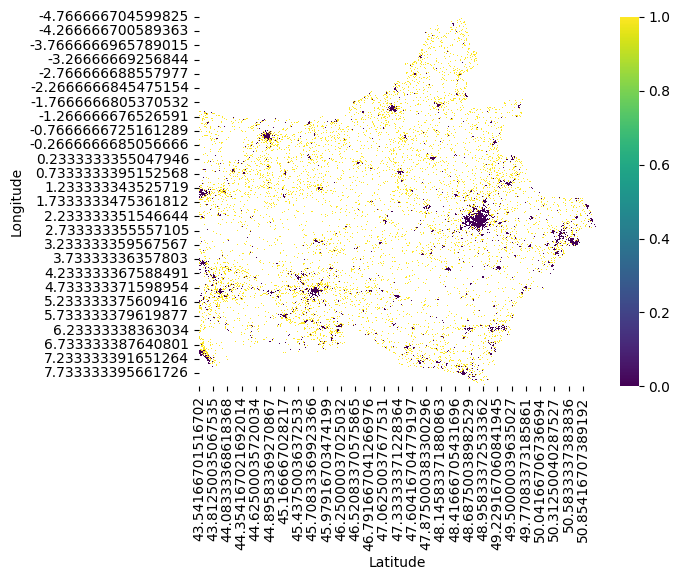

In [16]:
data = df[['Longitude', 'Latitude', 'power_outage_num']]

# Drop duplicates
data = data.drop_duplicates()

# Create pivot table
pivot = data.pivot(index='Longitude', columns='Latitude', values='power_outage_num')

# Plot heatmap
ax = sb.heatmap(pivot, cmap='viridis')
plt.show()


In [ ]:
!unzip '/content/drive/MyDrive/datasets/population.zip'

In [25]:
df2 = pd.read_csv("population_fra_2019-07-01.csv")

In [ ]:
df2

In [ ]:
data = df2.iloc[:len(df2["Lat"]/2),[0,1,2]]
data.drop_duplicates(inplace=True)
pivot = data.pivot(index='Lat', columns='Lon', values='Population')
ax = sb.heatmap(pivot, cmap='viridis')
plt.show()

# **VALIDATING THRESHOLD OF POWER OUTAGE 1 --> l2ena en el internet download speed low bs light intensity kan a3la 7aga 3adi --> no relation kaweya**

In [ ]:
df['avg_d_kbps'].describe()

In [ ]:
# Define the download speed threshold --> first quartile value
download_speed_threshold = 2.061325e+04
# Filter the DataFrame to find rows with download speed below the threshold
filtered_data = df[df['avg_d_kbps'] < download_speed_threshold]
# Identify the maximum light intensity in the filtered data
max_light_intensity = filtered_data['Light_intesity'].max()
print(max_light_intensity)

# **VALIDATING THRESHOLD OF POWER OUTAGE 2 --> Calculate the 5th percentile**

In [ ]:
# Calculate the 5th percentile of Light_intensity
threshold = df['Light_intesity'].quantile(0.05)

power_outages = df[df['Light_intesity'] < threshold]
print(threshold)
len(power_outages['Light_intesity'])

# **VALIDATING THRESHOLD OF POWER OUTAGE 3 --> clustering**

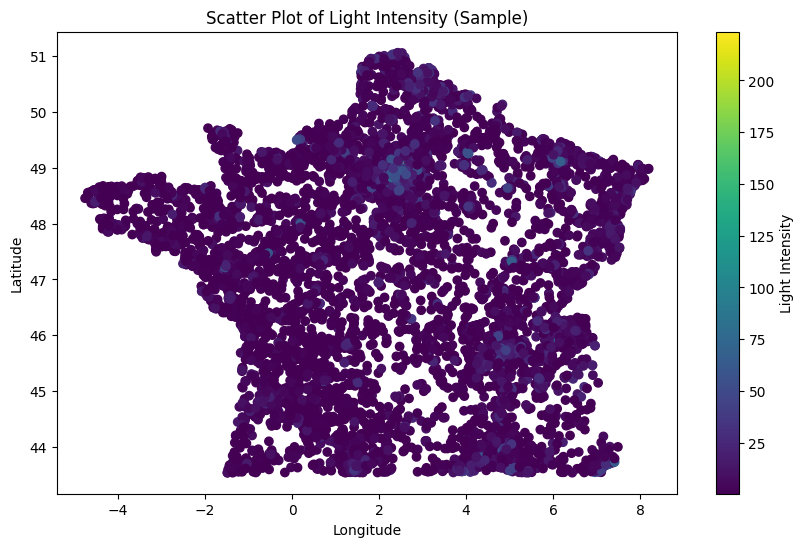

In [18]:
# bashof shaklohom f cluster 3amel ezay w dh sample mn el data msh kolaha

sample_df = df.sample(frac=0.01, random_state=42)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(sample_df['Longitude'], sample_df['Latitude'], c=sample_df['Light_intesity'], cmap='viridis')
plt.colorbar(scatter, label='Light Intensity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Light Intensity (Sample)')
plt.show()

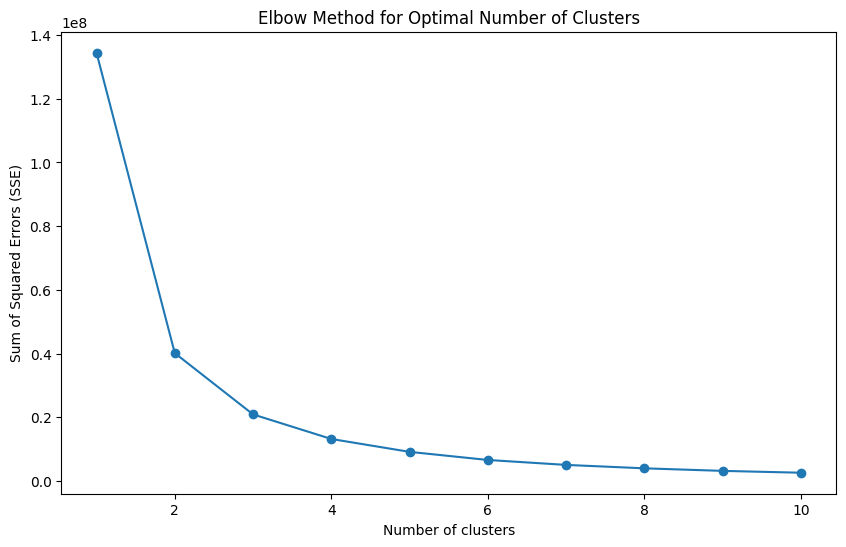

In [19]:
# elbow method

X = df[['Light_intesity']]

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [20]:
# optimal number of clusters from the Elbow method --> mfrod 3 bs hakhleha 5 3shan tb2a more reasonable
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Identify the cluster with the lowest light intensity
lowest_cluster = df.groupby('Cluster')['Light_intesity'].mean().idxmin()
threshold = df[df['Cluster'] == lowest_cluster]['Light_intesity'].max()

print(threshold)

6.5817776


In [21]:
power_outages = df[df['Light_intesity'] < threshold]
len(power_outages['Light_intesity'])

505609

# **GENERATING POWER OUTAGE COLUMN**

In [7]:
df['power_outage'] = df['Light_intesity'] < 6.856835

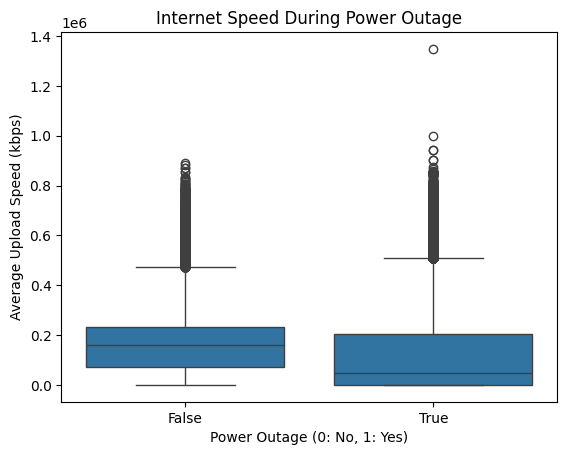

In [17]:
sb.boxplot(data=df, x='power_outage', y='avg_u_kbps')
plt.title('Internet Speed During Power Outage')
plt.xlabel('Power Outage (0: No, 1: Yes)')
plt.ylabel('Average Upload Speed (kbps)')
plt.show()

                power_outage  Light_intesity
power_outage        1.000000       -0.734376
Light_intesity     -0.734376        1.000000


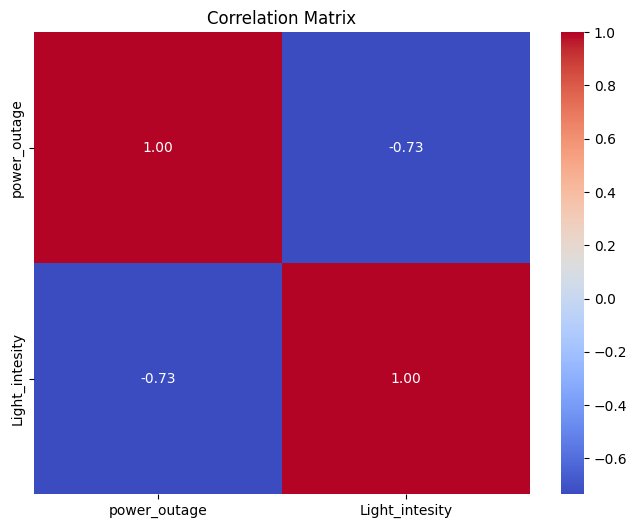

In [18]:
# validate en relation between power outage and light intensity 3akseya when light intensity decreases power outage increases

corr_matrix = df[['power_outage', 'Light_intesity']].corr()
print(corr_matrix)
# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Count the number of power outages by location
outage_counts = df.groupby(['Longitude', 'Latitude']).size().reset_index(name='Outage_Count')

# Sort by the number of outages in descending order
outage_counts_sorted = outage_counts.sort_values(by='Outage_Count', ascending=False)

print(outage_counts_sorted.head(10))

        Longitude   Latitude  Outage_Count
16      -4.758333  48.525000             4
346674   8.195833  48.983334             4
346660   8.170833  48.975000             4
346661   8.175000  48.975000             4
346662   8.179167  48.975000             4
346665   8.183333  48.970834             4
199885   2.933333  49.925000             4
199912   2.933333  50.537500             4
199913   2.933333  50.566667             4
199914   2.933333  50.570834             4


# **Linear regression**

In [21]:
def LR(X,Y):
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    n = len(X)
    numerator = 0
    denomenator = 0
    for i in range(n):
        numerator += (X[i] - mean_X) * (Y[i] - mean_Y)
        denomenator += (X[i] - mean_X) ** 2
    a = numerator / denomenator
    b = mean_Y - (a * mean_X)
    return a,b

2131.9274721277716 150274.38539563835


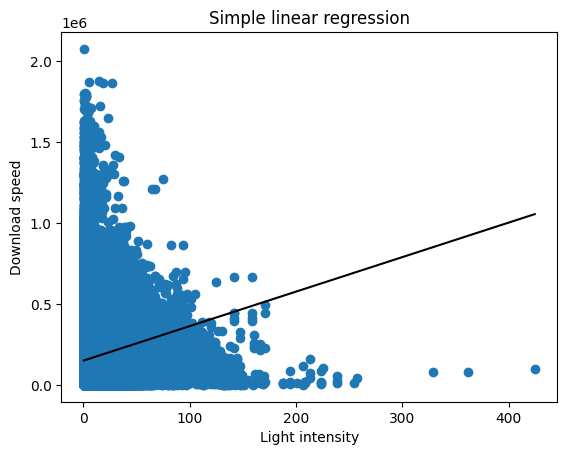

In [22]:
X_test = np.linspace(df["Light_intesity"].min(),df['Light_intesity'].max(),num=100)
a,b = LR(df["Light_intesity"],df["avg_d_kbps"])
print(a,b)
Y_pred_test = a*X_test + b
plt.title("Simple linear regression")
plt.scatter(df['Light_intesity'],df['avg_d_kbps'])
plt.plot(X_test,Y_pred_test,color = "black");
plt.xlabel('Light intensity')
plt.ylabel('Download speed')
plt.show()

In [23]:
    Y_pred_train = a*df['Light_intesity'] + b
    TSS = sum([(y - np.mean(df['avg_d_kbps']))**2 for y in df['avg_d_kbps']])
    RSS = sum([(y - y_pred_train)**2 for y, y_pred_train in zip(df['avg_d_kbps'], Y_pred_train)])
    R2 = 1 - RSS/TSS
    print(f'R2 for features Light intensity & Download speed is: {R2}')

R2 for features Light intensity & Download speed is: 0.03007144780442872


1503.5338285970176 120042.82644008716


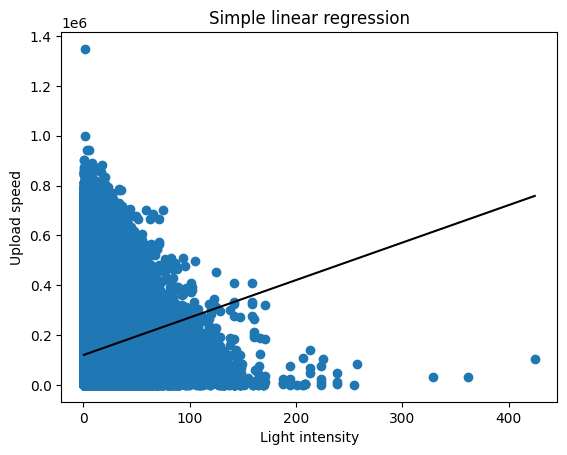

In [24]:
X_test = np.linspace(df["Light_intesity"].min(),df['Light_intesity'].max(),num=100)
a,b = LR(df["Light_intesity"],df["avg_u_kbps"])
print(a,b)
Y_pred_test = a*X_test + b
plt.title("Simple linear regression")
plt.scatter(df['Light_intesity'],df['avg_u_kbps'])
plt.plot(X_test,Y_pred_test,color = "black");
plt.xlabel('Light intensity')
plt.ylabel('Upload speed')
plt.show()

In [25]:
Y_pred_train = a*df['Light_intesity'] + b
TSS = sum([(y - np.mean(df['avg_u_kbps']))**2 for y in df['avg_u_kbps']])
RSS = sum([(y - y_pred_train)**2 for y, y_pred_train in zip(df['avg_u_kbps'], Y_pred_train)])
R2 = 1 - RSS/TSS
print(f'R2 for features Light intensity & Upload speed is: {R2}')

R2 for features Light intensity & Upload speed is: 0.021395142099177478


0.19762501436810723 0.9431996247231975


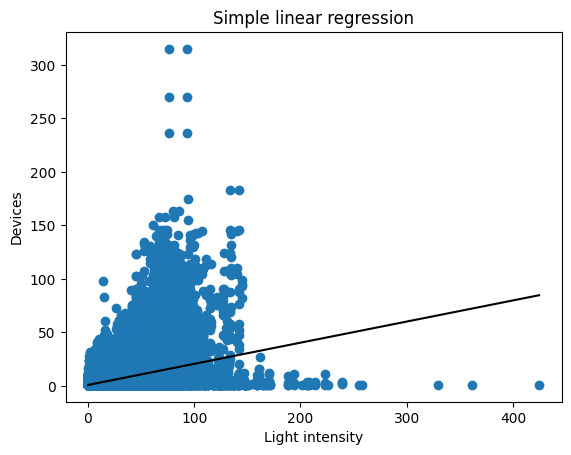

In [26]:
X_test = np.linspace(df["Light_intesity"].min(),df['Light_intesity'].max(),num=100)
a,b = LR(df["Light_intesity"],df["devices"])
print(a,b)
Y_pred_test = a*X_test + b
plt.title("Simple linear regression")
plt.scatter(df['Light_intesity'],df['devices'])
plt.plot(X_test,Y_pred_test,color = "black");
plt.xlabel('Light intensity')
plt.ylabel('Devices')
plt.show()

In [27]:
Y_pred_train = a*df['Light_intesity'] + b
TSS = sum([(y - np.mean(df['avg_d_kbps']))**2 for y in df['devices']])
RSS = sum([(y - y_pred_train)**2 for y, y_pred_train in zip(df['devices'], Y_pred_train)])
R2 = 1 - RSS/TSS
print(f'R2 for features Light intensity & amount of Devices is: {R2}')

R2 for features Light intensity & amount of Devices is: 0.9999999994435712


In [ ]:
#####################################################################################################
# Apply multiple linear regression on the 3 features "Light_intesity", "avg_d_kbps", "avg_u_kbps" and consider the target is "Light_intesity
# Calculate the r2_score for the model you get its parameters
#####################################################################################################

In [28]:
#multiple linear regression
def calculate_w(X,Y):
    XT = X.T
    XT_X = XT @ X
    XT_X_inv = np.linalg.pinv(XT_X)
    W = XT_X_inv @ XT @ Y

    return W

In [29]:
light = np.array(df['Light_intesity'])
download = np.array(df['avg_d_kbps'])
upload = np.array(df['avg_u_kbps'])
all = [download,upload]
all.append(np.ones(len(light)))
all = np.array(all).T
B = calculate_w(all,light)
print(B)

[ 1.73032794e-05 -4.27709732e-06  6.33182864e+00]


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming you already have your dataframe loaded as `df`

# Define features and target
features = ["avg_d_kbps", "avg_u_kbps"]
target = "Light_intesity"

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Output the model parameters and R2 score
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R2 Score:", r2)


Intercept: 6.3252644572378145
Coefficients: [ 1.73280813e-05 -4.33749083e-06]
R2 Score: 0.030422737670198652


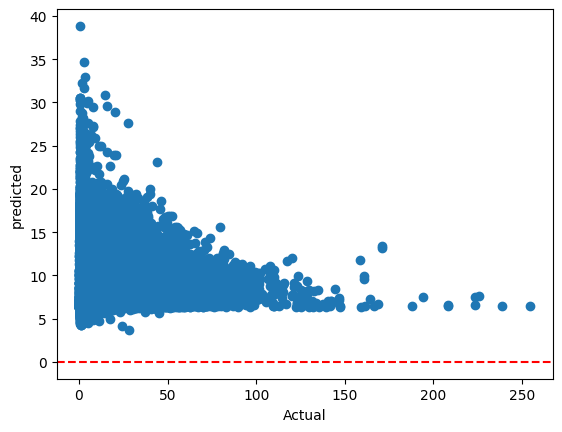

In [31]:
# (difference between predicted and actual values) to check if there's a pattern.

import matplotlib.pyplot as plt
predicted = y_pred
plt.scatter(y_test, predicted)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("predicted")
plt.show()

# **Regression Model **

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
data =df
X = data[['Light_intesity', 'avg_d_kbps']]  # Replace with actual feature names
y = data['power_outage']  # Replace with your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 0.0, MSE: 0.0, RMSE: 0.0


This suggests that severe radiance declines are strongly associated with poor internet performance.
minor variations in radiance may not significantly affect internet performance.